In [ ]:
import os
from dotenv import load_dotenv

APP_FOLDER = "../"
load_dotenv(os.path.join(APP_FOLDER, ".env"))

In [ ]:
DATA_CLEAN = os.getenv("DATA_CLEAN")
DATA_FILE = os.getenv("DATA_FILE")

data_folder = os.path.join(APP_FOLDER, DATA_CLEAN)
data_file = os.path.join(APP_FOLDER, DATA_CLEAN, DATA_FILE)

In [1]:
data_folder = "/kaggle/input/architecture-custom/clean"
data_file = "/kaggle/input/architecture-custom/clean/data.yaml"

## Load dataset

In [2]:
from pathlib import Path
from PIL import Image

IMG_EXTS = {".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"}

def yolo_xywhn_to_xyxy(x, y, w, h, W, H):
    x1 = (x - w / 2) * W
    y1 = (y - h / 2) * H
    x2 = (x + w / 2) * W
    y2 = (y + h / 2) * H
    x1 = max(0.0, min(x1, W - 1.0))
    y1 = max(0.0, min(y1, H - 1.0))
    x2 = max(0.0, min(x2, W - 1.0))
    y2 = max(0.0, min(y2, H - 1.0))
    return [x1, y1, x2, y2]

def build_items(split_dir):
    split_dir = Path(split_dir)
    img_dir = split_dir / "images"
    lbl_dir = split_dir / "labels"

    img_paths = sorted([p for p in img_dir.rglob("*") if p.suffix in IMG_EXTS])

    items = []
    for ip in img_paths:
        lp = lbl_dir / (ip.stem + ".txt")
        W, H = Image.open(ip).size

        boxes = []
        labels = []

        if lp.exists():
            for line in lp.read_text(encoding="utf-8", errors="ignore").splitlines():
                line = line.strip()
                if not line:
                    continue
                c, x, y, w, h = line.split()[:5]
                c = int(float(c))
                x, y, w, h = map(float, (x, y, w, h))
                boxes.append(yolo_xywhn_to_xyxy(x, y, w, h, W, H))
                labels.append(c+1)  # 0 это background

        items.append(
            {
                "image_path": str(ip),
                "boxes": boxes,     # xyxy в пикселях
                "labels": labels,   # int
            }
        )
    return items

def build_all(root_clean_dir):
    root = Path(root_clean_dir)
    train_items = build_items(root / "train")
    val_items = build_items(root / "valid")
    test_items = build_items(root / "test")
    return train_items, val_items, test_items

# пример
train_items, val_items, test_items = build_all(data_folder)

In [3]:
import yaml

with open(data_file, "r", encoding="utf-8") as f:
    d = yaml.safe_load(f)

nc = int(d["nc"])
names = list(d["names"])

id2name = {i: n for i, n in enumerate(names)}
name2id = {n: i for i, n in enumerate(names)}

num_classes = 1 + nc  # num_classes = 1 background + K классов

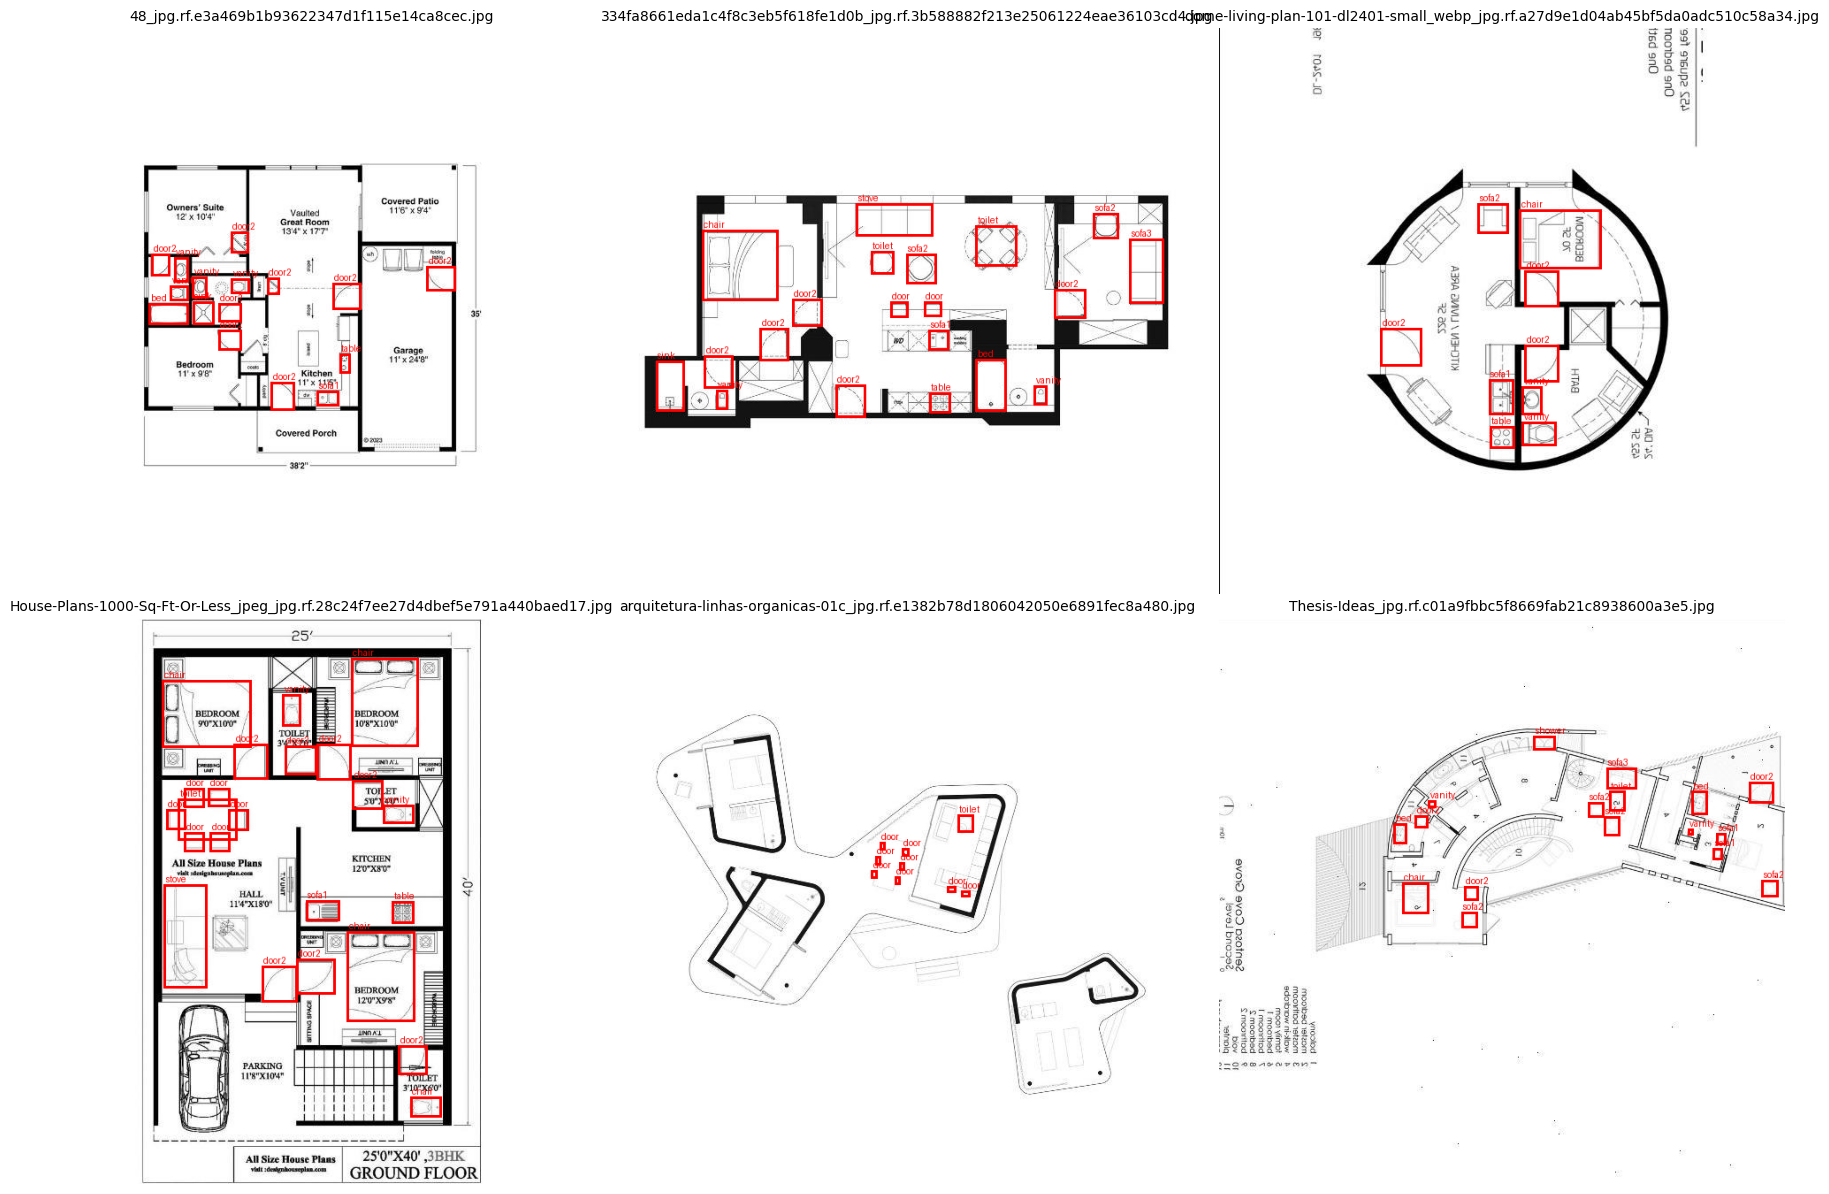

In [4]:
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

def label_to_name(lbl, id2name):
    if lbl in id2name:
        return id2name[lbl]
    if (lbl - 1) in id2name:
        return id2name[lbl - 1]
    return str(lbl)

def draw_sample(items, id2name, k=4, cols=2):
    pick = random.sample(items, k=min(k, len(items)))
    rows = (len(pick) + cols - 1) // cols
    font = ImageFont.load_default()

    plt.figure(figsize=(6 * cols, 6 * rows))
    for i, it in enumerate(pick, 1):
        img = Image.open(it["image_path"]).convert("RGB")
        d = ImageDraw.Draw(img)

        for box, lbl in zip(it["boxes"], it["labels"]):
            x1, y1, x2, y2 = map(float, box)
            name = label_to_name(int(lbl), id2name)
            d.rectangle([x1, y1, x2, y2], outline=(255, 0, 0), width=3)
            d.text((x1 + 2, max(0, y1 - 12)), name, fill=(255, 0, 0), font=font)

        ax = plt.subplot(rows, cols, i)
        ax.imshow(img)
        ax.set_title(Image.open(it["image_path"]).filename.split("/")[-1], fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

draw_sample(train_items, id2name, k=6, cols=3)

## Let's train

#### Data preparation

In [5]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class DrawingDataset(Dataset):
    """
    items: list[dict], каждый dict:
      {
        "image_path": str,
        "boxes": [[x1,y1,x2,y2], ...]  float, пиксели
        "labels": [int, ...]          int
      }
    """
    def __init__(self, items, transforms=None):
        self.items = items
        self.transforms = transforms

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i):
        it = self.items[i]
        img = cv2.imread(it["image_path"], cv2.IMREAD_COLOR)
        if img is None:
            raise RuntimeError(f"failed to read: {it['image_path']}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        boxes = np.array(it.get("boxes", []), dtype=np.float32).reshape(-1, 4)
        labels = np.array(it.get("labels", []), dtype=np.int64).reshape(-1)

        if self.transforms is not None:
            out = self.transforms(image=img, bboxes=boxes.tolist(), labels=labels.tolist())
            img = out["image"]
            img = img.float().div(255.0)  # float в диапазоне [0,1]
            boxes = torch.tensor(out["bboxes"], dtype=torch.float32)
            labels = torch.tensor(out["labels"], dtype=torch.int64)
        else:
            img = ToTensorV2()(image=img)["image"]
            img = img.float().div(255.0)  # float в диапазоне [0,1]
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,          # (N,4) xyxy
            "labels": labels,        # (N,)
            "image_id": torch.tensor([i], dtype=torch.int64),
        }
        return img, target

In [6]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def build_transforms(train=True):
    if train:
        return A.Compose(
            [
                A.LongestMaxSize(max_size=640),
                A.PadIfNeeded(min_height=640, min_width=640, border_mode=cv2.BORDER_CONSTANT),

                A.OneOf(  # поворот на фиксированные углы, чтобы мебель встречалась под любыми ориентациями
                    [
                        A.Affine(rotate=(45, 45), border_mode=cv2.BORDER_CONSTANT, p=1.0),   # поворот ровно на 45°
                        A.Affine(rotate=(90, 90), border_mode=cv2.BORDER_CONSTANT, p=1.0),   # поворот ровно на 90°
                        A.Affine(rotate=(135, 135), border_mode=cv2.BORDER_CONSTANT, p=1.0), # поворот ровно на 135°
                        A.Affine(rotate=(180, 180), border_mode=cv2.BORDER_CONSTANT, p=1.0), # поворот ровно на 180°
                    ],
                    p=0.6,
                ),

                A.Affine(  # сдвиг плюс независимый масштаб по x/y, чтобы имитировать разные пропорции и растяжения
                    translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},  # случайный сдвиг объекта по кадру
                    scale={"x": (0.7, 1.3), "y": (0.7, 1.3)},  # независимое растяжение/сжатие по осям
                    rotate=(0, 0),  # здесь поворот выключен, он делается выше фиксированными углами
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT,
                ),

                A.HorizontalFlip(p=0.5),  # зеркалим план по горизонтали
                A.RandomBrightnessContrast(p=0.25),  # меняем контраст и яркость линий и фона
                A.RandomGamma(p=0.35),  # меняем гамму, чтобы линии выглядели толще/тоньше по контрасту
                A.InvertImg(p=0.15),  # делаем негатив: фон темный, линии светлые

                ToTensorV2(),
            ],
            bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"], min_visibility=0.01),
        )

    return A.Compose(
        [
            A.LongestMaxSize(max_size=640),
            A.PadIfNeeded(min_height=640, min_width=640, border_mode=cv2.BORDER_CONSTANT),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
    )

#### Model builder

In [7]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models import ResNet50_Weights

def build_model(num_classes, trainable_layers=2):
    backbone = resnet_fpn_backbone(
        backbone_name="resnet50",
        weights=ResNet50_Weights.DEFAULT,
        trainable_layers=trainable_layers,
    )

    anchor_generator = AnchorGenerator(
        sizes=((8, 16, 32, 64, 128, 256),) * 5,
        aspect_ratios=((0.5, 1.0, 2.0),) * 5,
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,

        box_score_thresh=0.5,
        box_nms_thresh=0.4,
        box_detections_per_img=100,

        rpn_nms_thresh=0.6,
        rpn_pre_nms_top_n_test=600,
        rpn_post_nms_top_n_test=300,
    )

    model.transform.min_size = (640,)
    model.transform.max_size = 640
    return model

#### Runner class

In [9]:
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from contextlib import nullcontext
from torchvision.ops import nms, box_iou
from torchmetrics.detection.mean_ap import MeanAveragePrecision


class Runner:
    def __init__(
        self,
        model,
        optimizer,
        scheduler,
        train_items,
        val_items=None,
        dataset_cls=None,
        transforms_fn=None,
        epochs=10,
        batch_size=4,
        num_workers=2,
        val_iou_thr=0.5,
        val_conf_thr=0.25,
        val_nms_thr=0.6,
        box_reg_weight=2.0,
    ):
        self.model = model
        self.opt = optimizer
        self.sch = scheduler

        self.train_items = train_items
        self.val_items = val_items or []

        if dataset_cls is None or transforms_fn is None:
            raise ValueError("dataset_cls and transforms_fn are required")
        self.dataset_cls = dataset_cls
        self.transforms_fn = transforms_fn

        self.epochs = epochs
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.val_iou_thr = val_iou_thr
        self.val_conf_thr = val_conf_thr
        self.val_nms_thr = val_nms_thr

        self.box_reg_weight = box_reg_weight
        
        self.device = self._infer_device(self.model)
        if self.device.type == "cpu":
            self.model = self.model.to(self.device)

        self.amp = (self.device.type == "cuda")
        self.num_workers = self.num_workers if self.device.type == "cuda" else 0

        ds_tr = self.dataset_cls(self.train_items, transforms=self.transforms_fn(train=True))
        ds_va = self.dataset_cls(self.val_items, transforms=self.transforms_fn(train=False)) if self.val_items else None

        dl_kwargs = dict(
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
            pin_memory=(self.device.type == "cuda"),
            persistent_workers=(self.num_workers > 0),
        )

        self.dl_tr = DataLoader(ds_tr, shuffle=True, **dl_kwargs)
        self.dl_va = DataLoader(ds_va, shuffle=False, **dl_kwargs) if ds_va is not None else None

        self.scaler = torch.amp.GradScaler("cuda", enabled=self.amp)
        self.autocast_ctx = (lambda: torch.amp.autocast(device_type="cuda", enabled=True)) if self.amp else (lambda: nullcontext())

        self.history = []

    @staticmethod
    def _infer_device(model):
        try:
            return next(model.parameters()).device
        except StopIteration:
            return torch.device("cpu")

    @staticmethod
    def collate_fn(batch):
        imgs, targets = zip(*batch)
        return list(imgs), list(targets)

    @staticmethod
    def _set_bn_eval(m):
        if isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
            m.eval()

    def _to_device(self, images, targets):
        images = [img.to(self.device, non_blocking=True) for img in images]
        targets = [{k: v.to(self.device, non_blocking=True) for k, v in t.items()} for t in targets]
        return images, targets

    @staticmethod
    def _init_loss_sums():
        return {
            "loss_total": 0.0,
            "loss_classifier": 0.0,
            "loss_box_reg": 0.0,
            "loss_objectness": 0.0,
            "loss_rpn_box_reg": 0.0,
        }

    @staticmethod
    def _accum_loss_sums(sums, loss_dict, loss_total):
        sums["loss_total"] += float(loss_total.detach().cpu().item())
        for k in ("loss_classifier", "loss_box_reg", "loss_objectness", "loss_rpn_box_reg"):
            if k in loss_dict:
                sums[k] += float(loss_dict[k].detach().cpu().item())

    @staticmethod
    def _finalize_loss_means(sums, n):
        n = max(int(n), 1)
        return {k: v / n for k, v in sums.items()}

    def _pr_from_preds(self, preds, targets):
        tp = fp = fn = 0
    
        for out, tgt in zip(preds, targets):
            gt_boxes = tgt["boxes"]
            pred_boxes = out["boxes"]
            scores = out["scores"]
    
            keep = scores >= self.val_conf_thr  # score threshold: фильтруем слабые боксы перед NMS и перед подсчетом P/R
            pred_boxes = pred_boxes[keep]
            scores = scores[keep]
    
            if pred_boxes.numel() > 0:
                keep2 = nms(pred_boxes, scores, self.val_nms_thr)  # NMS IoU threshold: склеивает пересекающиеся боксы
                pred_boxes = pred_boxes[keep2]
                scores = scores[keep2]
    
            if pred_boxes.numel() == 0 and gt_boxes.numel() == 0:
                continue
            if pred_boxes.numel() == 0:
                fn += int(gt_boxes.shape[0])
                continue
            if gt_boxes.numel() == 0:
                fp += int(pred_boxes.shape[0])
                continue
    
            ious = box_iou(pred_boxes, gt_boxes)
            best_iou, best_j = ious.max(dim=1)
            matched = best_iou >= self.val_iou_thr  # IoU threshold для мэтчинга pred->gt при подсчете P/R
    
            tp += int(matched.sum().item())
            fp += int((~matched).sum().item())
            used = set(best_j[matched].tolist())
            fn += int(gt_boxes.shape[0] - len(used))
    
        p = tp / max(tp + fp, 1)
        r = tp / max(tp + fn, 1)
        return float(p), float(r)

    def train_epoch(self, ep):
        self.model.train()
        sums = self._init_loss_sums()
        n = 0

        for images, targets in tqdm(self.dl_tr, total=len(self.dl_tr), desc=f"train {ep}/{self.epochs}", leave=False):
            images, targets = self._to_device(images, targets)
            self.opt.zero_grad(set_to_none=True)

            with self.autocast_ctx():
                loss_dict = self.model(images, targets)
                loss_total = (
                    loss_dict["loss_classifier"]
                    + self.box_reg_weight * loss_dict["loss_box_reg"]  # вес регрессии бокса: множитель для loss_box_reg в суммарном лоссе
                    + loss_dict["loss_objectness"]
                    + loss_dict["loss_rpn_box_reg"]
                )

            if self.amp:
                self.scaler.scale(loss_total).backward()
                self.scaler.step(self.opt)
                self.scaler.update()
            else:
                loss_total.backward()
                self.opt.step()

            self._accum_loss_sums(sums, loss_dict, loss_total)
            n += 1

        return self._finalize_loss_means(sums, n)

    @torch.no_grad()
    def validate(self, ep):
        if self.dl_va is None:
            return None

        self.model.eval()
        metric = MeanAveragePrecision(box_format="xyxy", iou_type="bbox").to(self.device)

        sums = self._init_loss_sums()
        n = 0
        p_acc = 0.0
        r_acc = 0.0

        for images, targets in tqdm(self.dl_va, total=len(self.dl_va), desc=f"val {ep}/{self.epochs}", leave=False):
            images, targets = self._to_device(images, targets)

            self.model.train()
            self.model.apply(self._set_bn_eval)
            with self.autocast_ctx():
                loss_dict = self.model(images, targets)
                loss_total = (
                    loss_dict["loss_classifier"]
                    + self.box_reg_weight * loss_dict["loss_box_reg"]  # вес регрессии бокса: множитель для loss_box_reg в суммарном лоссе
                    + loss_dict["loss_objectness"]
                    + loss_dict["loss_rpn_box_reg"]
                )
            self._accum_loss_sums(sums, loss_dict, loss_total)

            self.model.eval()
            preds = self.model(images)

            metric.update(preds, targets)
            p, r = self._pr_from_preds(preds, targets)
            p_acc += p
            r_acc += r
            n += 1

        out = metric.compute()
        loss_means = self._finalize_loss_means(sums, n)

        return {
            **loss_means,
            "P": float(p_acc / max(n, 1)),
            "R": float(r_acc / max(n, 1)),
            "mAP50": float(out["map_50"].item()),
            "mAP50_95": float(out["map"].item()),
        }

    def fit(self):
        best_map50 = float("-inf")
    
        for ep in range(1, self.epochs + 1):
            tr = self.train_epoch(ep)
            if self.sch is not None:
                self.sch.step()
    
            va = self.validate(ep)
    
            row = {"epoch": ep, "train": tr, "val": va}
            self.history.append(row)
            self.model.metrics_history = self.history
    
            torch.save(self.model.state_dict(), "last.pt")
            if va is not None and va["mAP50"] > best_map50:
                best_map50 = va["mAP50"]
                torch.save(self.model.state_dict(), "best.pt")
    
            if va is None:
                print(
                    f"[{ep:02d}/{self.epochs:02d}] "
                    f"total_loss={tr['loss_total']:.3f} cls_loss={tr['loss_classifier']:.3f} box_loss={tr['loss_box_reg']:.3f} "
                    f"obj_loss={tr['loss_objectness']:.3f} rpn_loss={tr['loss_rpn_box_reg']:.3f}"
                )
            else:
                print(
                    f"[{ep:02d}/{self.epochs:02d}] "
                    f"total_loss={va['loss_total']:.3f} cls_loss={va['loss_classifier']:.3f} box_loss={va['loss_box_reg']:.3f} "
                    f"obj_loss={va['loss_objectness']:.3f} rpn_loss={va['loss_rpn_box_reg']:.3f} | "
                    f"P={va['P']:.2f} R={va['R']:.2f} mAP50={va['mAP50']:.3f} mAP50-95={va['mAP50_95']:.3f}"
                )
    
        return self.model

#### Train model

In [10]:
model = build_model(num_classes=num_classes)  # num_classes включая background как 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=3e-4, weight_decay=3e-4)

epochs = 25
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

runner = Runner(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_items=train_items,
    val_items=val_items,
    dataset_cls=DrawingDataset,
    transforms_fn=build_transforms,
    epochs=epochs,
    batch_size=16,
    num_workers=4,
)

trained_model = runner.fit()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s] 


train 1/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 1/25:   0%|          | 0/13 [00:00<?, ?it/s]

[01/25] total_loss=2.257 cls_loss=0.689 box_loss=0.537 obj_loss=0.327 rpn_loss=0.167 | P=0.72 R=0.10 mAP50=0.022 mAP50-95=0.009


train 2/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 2/25:   0%|          | 0/13 [00:00<?, ?it/s]

[02/25] total_loss=1.914 cls_loss=0.579 box_loss=0.511 obj_loss=0.170 rpn_loss=0.144 | P=0.73 R=0.25 mAP50=0.078 mAP50-95=0.038


train 3/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 3/25:   0%|          | 0/13 [00:00<?, ?it/s]

[03/25] total_loss=1.614 cls_loss=0.479 box_loss=0.438 obj_loss=0.128 rpn_loss=0.130 | P=0.77 R=0.41 mAP50=0.200 mAP50-95=0.108


train 4/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 4/25:   0%|          | 0/13 [00:00<?, ?it/s]

[04/25] total_loss=1.538 cls_loss=0.461 box_loss=0.419 obj_loss=0.113 rpn_loss=0.127 | P=0.75 R=0.52 mAP50=0.289 mAP50-95=0.155


train 5/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 5/25:   0%|          | 0/13 [00:00<?, ?it/s]

[05/25] total_loss=1.351 cls_loss=0.385 box_loss=0.389 obj_loss=0.084 rpn_loss=0.104 | P=0.80 R=0.58 mAP50=0.388 mAP50-95=0.224


train 6/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 6/25:   0%|          | 0/13 [00:00<?, ?it/s]

[06/25] total_loss=1.325 cls_loss=0.370 box_loss=0.388 obj_loss=0.084 rpn_loss=0.096 | P=0.81 R=0.61 mAP50=0.413 mAP50-95=0.239


train 7/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 7/25:   0%|          | 0/13 [00:00<?, ?it/s]

[07/25] total_loss=1.302 cls_loss=0.362 box_loss=0.385 obj_loss=0.075 rpn_loss=0.096 | P=0.79 R=0.63 mAP50=0.440 mAP50-95=0.251


train 8/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 8/25:   0%|          | 0/13 [00:00<?, ?it/s]

[08/25] total_loss=1.183 cls_loss=0.315 box_loss=0.349 obj_loss=0.081 rpn_loss=0.089 | P=0.81 R=0.70 mAP50=0.490 mAP50-95=0.301


train 9/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 9/25:   0%|          | 0/13 [00:00<?, ?it/s]

[09/25] total_loss=1.148 cls_loss=0.304 box_loss=0.345 obj_loss=0.062 rpn_loss=0.092 | P=0.83 R=0.72 mAP50=0.515 mAP50-95=0.314


train 10/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 10/25:   0%|          | 0/13 [00:00<?, ?it/s]

[10/25] total_loss=1.122 cls_loss=0.299 box_loss=0.343 obj_loss=0.058 rpn_loss=0.079 | P=0.81 R=0.74 mAP50=0.565 mAP50-95=0.345


train 11/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 11/25:   0%|          | 0/13 [00:00<?, ?it/s]

[11/25] total_loss=1.056 cls_loss=0.284 box_loss=0.321 obj_loss=0.055 rpn_loss=0.075 | P=0.83 R=0.77 mAP50=0.600 mAP50-95=0.382


train 12/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 12/25:   0%|          | 0/13 [00:00<?, ?it/s]

[12/25] total_loss=1.052 cls_loss=0.287 box_loss=0.321 obj_loss=0.048 rpn_loss=0.077 | P=0.82 R=0.78 mAP50=0.596 mAP50-95=0.381


train 13/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 13/25:   0%|          | 0/13 [00:00<?, ?it/s]

[13/25] total_loss=1.044 cls_loss=0.277 box_loss=0.324 obj_loss=0.047 rpn_loss=0.072 | P=0.83 R=0.79 mAP50=0.601 mAP50-95=0.376


train 14/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 14/25:   0%|          | 0/13 [00:00<?, ?it/s]

[14/25] total_loss=0.994 cls_loss=0.256 box_loss=0.311 obj_loss=0.047 rpn_loss=0.068 | P=0.83 R=0.81 mAP50=0.642 mAP50-95=0.414


train 15/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 15/25:   0%|          | 0/13 [00:00<?, ?it/s]

[15/25] total_loss=0.974 cls_loss=0.259 box_loss=0.305 obj_loss=0.039 rpn_loss=0.066 | P=0.81 R=0.85 mAP50=0.672 mAP50-95=0.441


train 16/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 16/25:   0%|          | 0/13 [00:00<?, ?it/s]

[16/25] total_loss=0.943 cls_loss=0.251 box_loss=0.296 obj_loss=0.040 rpn_loss=0.062 | P=0.84 R=0.82 mAP50=0.675 mAP50-95=0.444


train 17/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 17/25:   0%|          | 0/13 [00:00<?, ?it/s]

[17/25] total_loss=0.951 cls_loss=0.246 box_loss=0.302 obj_loss=0.038 rpn_loss=0.062 | P=0.84 R=0.84 mAP50=0.687 mAP50-95=0.451


train 18/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 18/25:   0%|          | 0/13 [00:00<?, ?it/s]

[18/25] total_loss=0.908 cls_loss=0.234 box_loss=0.290 obj_loss=0.035 rpn_loss=0.059 | P=0.83 R=0.85 mAP50=0.708 mAP50-95=0.474


train 19/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 19/25:   0%|          | 0/13 [00:00<?, ?it/s]

[19/25] total_loss=0.898 cls_loss=0.234 box_loss=0.285 obj_loss=0.036 rpn_loss=0.058 | P=0.85 R=0.84 mAP50=0.705 mAP50-95=0.471


train 20/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 20/25:   0%|          | 0/13 [00:00<?, ?it/s]

[20/25] total_loss=0.880 cls_loss=0.228 box_loss=0.280 obj_loss=0.035 rpn_loss=0.057 | P=0.84 R=0.87 mAP50=0.724 mAP50-95=0.489


train 21/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 21/25:   0%|          | 0/13 [00:00<?, ?it/s]

[21/25] total_loss=0.874 cls_loss=0.226 box_loss=0.278 obj_loss=0.034 rpn_loss=0.057 | P=0.84 R=0.86 mAP50=0.724 mAP50-95=0.491


train 22/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 22/25:   0%|          | 0/13 [00:00<?, ?it/s]

[22/25] total_loss=0.864 cls_loss=0.223 box_loss=0.276 obj_loss=0.033 rpn_loss=0.056 | P=0.85 R=0.86 mAP50=0.721 mAP50-95=0.492


train 23/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 23/25:   0%|          | 0/13 [00:00<?, ?it/s]

[23/25] total_loss=0.861 cls_loss=0.220 box_loss=0.277 obj_loss=0.031 rpn_loss=0.055 | P=0.84 R=0.86 mAP50=0.728 mAP50-95=0.496


train 24/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 24/25:   0%|          | 0/13 [00:00<?, ?it/s]

[24/25] total_loss=0.864 cls_loss=0.223 box_loss=0.277 obj_loss=0.032 rpn_loss=0.055 | P=0.84 R=0.87 mAP50=0.728 mAP50-95=0.497


train 25/25:   0%|          | 0/46 [00:00<?, ?it/s]

val 25/25:   0%|          | 0/13 [00:00<?, ?it/s]

[25/25] total_loss=0.861 cls_loss=0.221 box_loss=0.276 obj_loss=0.032 rpn_loss=0.055 | P=0.84 R=0.86 mAP50=0.727 mAP50-95=0.495


In [11]:
hist = runner.history

epochs = [h["epoch"] for h in hist]

train_total = [h["train"]["loss_total"] for h in hist]
val_total = [h["val"]["loss_total"] if h["val"] is not None else None for h in hist]

val_map50 = [h["val"]["mAP50"] if h["val"] is not None else None for h in hist]
val_map5095 = [h["val"]["mAP50_95"] if h["val"] is not None else None for h in hist]

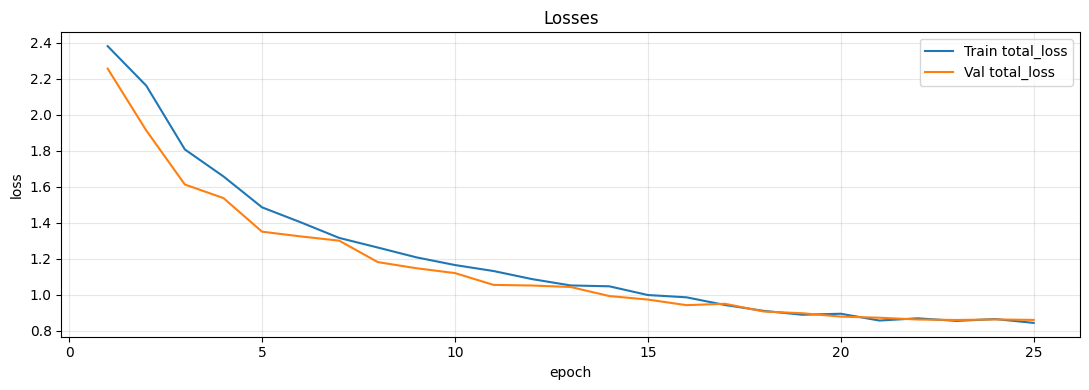

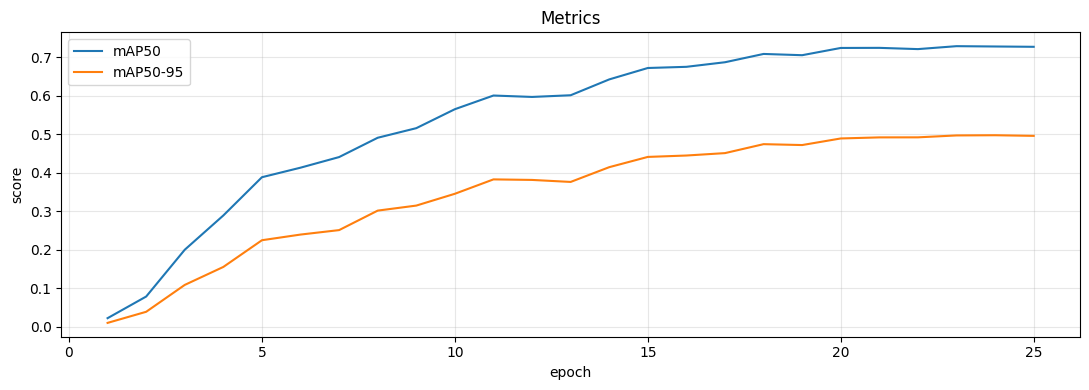

In [12]:
import matplotlib.pyplot as plt

def _plot_series(x, y, label):
    x2 = [xi for xi, yi in zip(x, y) if yi is not None]
    y2 = [yi for yi in y if yi is not None]
    plt.plot(x2, y2, label=label)

plt.figure(figsize=(11, 4))
plt.title("Losses")
_plot_series(epochs, train_total, "Train total_loss")
_plot_series(epochs, val_total, "Val total_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(11, 4))
plt.title("Metrics")
_plot_series(epochs, val_map50, "mAP50")
_plot_series(epochs, val_map5095, "mAP50-95")
plt.xlabel("epoch")
plt.ylabel("score")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Inference

#### Model wrapper

In [13]:
import torch
from typing import List, Dict
from torchvision.ops import nms


class FRCNNTorchScriptWrapper(torch.nn.Module):
    __constants__ = ["class_names"]

    def __init__(self, model: torch.nn.Module, conf: float = 0.6, nms_thr: float = 0.20, class_names: List[str] = None):
        super().__init__()
        self.model = model
        self.conf = float(conf)
        self.nms_thr = float(nms_thr)
        if class_names is None:
            class_names = []
        self.class_names = torch.jit.annotate(List[str], class_names)

    @torch.jit.export
    def get_class_names(self) -> List[str]:
        return self.class_names

    def forward(self, images: List[torch.Tensor]) -> Dict[str, torch.Tensor]:
        preds = torch.jit.annotate(List[Dict[str, torch.Tensor]], [])

        if torch.jit.is_scripting():
            out = self.model(images)
            preds = out[1]
        else:
            preds = self.model(images)

        boxes_all = torch.jit.annotate(List[torch.Tensor], [])
        scores_all = torch.jit.annotate(List[torch.Tensor], [])
        labels_all = torch.jit.annotate(List[torch.Tensor], [])
        batch_all = torch.jit.annotate(List[torch.Tensor], [])

        for i in range(len(preds)):
            d = preds[i]
            boxes = d["boxes"]
            scores = d["scores"]
            labels = d["labels"]

            keep = (scores >= self.conf) & (labels != 0)
            boxes = boxes[keep]
            scores = scores[keep]
            labels = labels[keep]

            if boxes.numel() > 0:
                k = nms(boxes, scores, self.nms_thr)  # class agnostic NMS
                boxes = boxes[k]
                scores = scores[k]
                labels = labels[k]

            n = boxes.size(0)
            if n > 0:
                batch_idx = torch.full((n,), i, dtype=torch.int64, device=boxes.device)
                boxes_all.append(boxes)
                scores_all.append(scores)
                labels_all.append(labels)
                batch_all.append(batch_idx)

        if len(boxes_all) == 0:
            dev = images[0].device
            return {
                "boxes": torch.zeros((0, 4), dtype=torch.float32, device=dev),
                "scores": torch.zeros((0,), dtype=torch.float32, device=dev),
                "labels": torch.zeros((0,), dtype=torch.int64, device=dev),
                "batch_idx": torch.zeros((0,), dtype=torch.int64, device=dev),
            }

        return {
            "boxes": torch.cat(boxes_all, dim=0),
            "scores": torch.cat(scores_all, dim=0),
            "labels": torch.cat(labels_all, dim=0),
            "batch_idx": torch.cat(batch_all, dim=0),
        }

In [14]:
model = build_model(num_classes=num_classes)
model.load_state_dict(torch.load("best.pt", map_location="cpu"), strict=True)
model.eval()
model.cpu()

class_names = ["bg"] + names
wrapper = FRCNNTorchScriptWrapper(model, conf=0.0, class_names=class_names).eval()

out_path = "fasterrcnn_resnet50.pt"
ts = torch.jit.script(wrapper)
ts.save(out_path)
print("saved:", out_path)

saved: fasterrcnn_resnet50.pt


In [15]:
m = torch.jit.load(out_path, map_location="cpu")
print(m.get_class_names())

['bg', 'bathtub', 'bed', 'bed2', 'chair', 'door', 'door2', 'shower', 'sink', 'sofa1', 'sofa2', 'sofa3', 'stove', 'table', 'toilet', 'vanity']
